# Analyzing Baltimore Civic Engagement During COVID-19 Pandemic

Look at Baltimore City 311 requests in March 2019 and March 2020 to see how COVID-19, closures, and stay-at-home orders have affected citizen engagement to estimate how these changes might affect voter turnout in Baltimore City in the 2020 elections. 

## import packages 

In [131]:
# data analysis
import pandas as pd

# geospatial analysis
import geopandas as gpd
import json

# data visualization
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

## import data 

311 data: https://data.baltimorecity.gov/City-Services/311-Customer-Service-Requests/9agw-sxsr

voting precinct shapefile data: https://github.com/nvkelso/election-geodata/blob/master/data/24-maryland/statewide/2016/md_2016_FEST.zip

MD precinct population data: https://planning.maryland.gov/Redistricting/Pages/2010/precinct.aspx

MD election data: https://www.elections.maryland.gov/elections/2018/election_data/index.html

In [2]:
# import 311 data
df_311 = pd.read_csv("311_Customer_Service_Requests.csv", low_memory = False)

In [3]:
# preview 311
df_311.head()

,SRRecordID,ServiceRequestNum,SRType,MethodReceived,CreatedDate,SRStatus,StatusDate,DueDate,CloseDate,Agency,...,Neighborhood,CouncilDistrict,PoliceDistrict,PolicePost,Latitude,Longitude,GeoLocation,2010 Census Wards Precincts,2010 Census Neighborhoods,Zip Codes
0,10-00267739,10-00267739,TEC-Footways Contract/Reconstruction,Phone,03/12/2010 10:17:31 AM,Open,03/12/2010 10:17:53 AM,03/12/2010 10:17:31 AM,NaN,Transportation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14-00602327,14-00602327,SW-HGW,API,08/12/2014 07:17:10 AM,Closed,10/29/2014 09:23:41 AM,09/11/2014 11:17:10 AM,10/29/2014 09:21:46 AM,Solid Waste,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10-00384725,10-00384725,TEC-Alley Contract/Reconstruction,Phone,04/20/2010 04:41:48 AM,Open,04/20/2010 04:41:54 AM,04/20/2010 04:41:48 AM,NaN,Transportation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10-00625763,10-00625763,TEC-Footways Contract/Reconstruction,Phone,07/09/2010 09:50:44 AM,Closed,12/01/2010 08:32:35 AM,07/09/2010 09:50:44 AM,11/27/2018 08:16:41 AM,Transportation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10-00648090,10-00648090,TEC-Footways Contract/Reconstruction,Phone,07/16/2010 11:01:30 AM,Open,07/16/2010 11:01:52 AM,07/16/2010 11:01:30 AM,NaN,Transportation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Edit 311 Data 

In [6]:
# look at data types in df
df_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4448358 entries, 0 to 4448357
Data columns (total 25 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   SRRecordID                   object 
 1   ServiceRequestNum            object 
 2   SRType                       object 
 3   MethodReceived               object 
 4   CreatedDate                  object 
 5   SRStatus                     object 
 6   StatusDate                   object 
 7   DueDate                      object 
 8   CloseDate                    object 
 9   Agency                       object 
 10  LastActivity                 object 
 11  LastActivityDate             object 
 12  Outcome                      object 
 13  Address                      object 
 14  ZipCode                      object 
 15  Neighborhood                 object 
 16  CouncilDistrict              float64
 17  PoliceDistrict               object 
 18  PolicePost                   object 
 19  

In [7]:
# filter dataframe
df_311_filter = df_311.filter(["SRRecordID", "CreatedDate", "Latitude", "Longitude"])

In [9]:
df_311_filter.tail()

,SRRecordID,CreatedDate,Latitude,Longitude
4448353,18-00039517,12/17/2017 07:00:00 PM,39.320929,-76.690258
4448354,5001K00000k5daKQAQ,08/10/2017 08:51:28 AM,39.286064,-76.581455
4448355,18-00015647,12/11/2017 07:00:00 PM,39.263769,-76.641645
4448356,18-00015397,12/17/2017 07:00:00 PM,39.261263,-76.640891
4448357,5001K00000jkPaJQAU,09/02/2017 07:26:36 PM,39.332385,-76.557806


In [10]:
# convert created date to a datetime data type
df_311_filter["CreatedDate"] = pd.to_datetime(df_311_filter["CreatedDate"])

In [12]:
# preview datetime edit
df_311_filter.tail()

,SRRecordID,CreatedDate,Latitude,Longitude
4448353,18-00039517,2017-12-17 19:00:00,39.320929,-76.690258
4448354,5001K00000k5daKQAQ,2017-08-10 08:51:28,39.286064,-76.581455
4448355,18-00015647,2017-12-11 19:00:00,39.263769,-76.641645
4448356,18-00015397,2017-12-17 19:00:00,39.261263,-76.640891
4448357,5001K00000jkPaJQAU,2017-09-02 19:26:36,39.332385,-76.557806


In [13]:
# create columns for month and year
df_311_filter["year"] = df_311_filter["CreatedDate"].dt.year
df_311_filter["month"] = df_311_filter["CreatedDate"].dt.month

In [15]:
# preview new columns
df_311_filter.tail()

,SRRecordID,CreatedDate,Latitude,Longitude,year,month
4448353,18-00039517,2017-12-17 19:00:00,39.320929,-76.690258,2017,12
4448354,5001K00000k5daKQAQ,2017-08-10 08:51:28,39.286064,-76.581455,2017,8
4448355,18-00015647,2017-12-11 19:00:00,39.263769,-76.641645,2017,12
4448356,18-00015397,2017-12-17 19:00:00,39.261263,-76.640891,2017,12
4448357,5001K00000jkPaJQAU,2017-09-02 19:26:36,39.332385,-76.557806,2017,9


In [16]:
# keep only the data created in any year in march
df_311_march = df_311_filter[df_311_filter["month"]==3]

In [19]:
# preview filtered df
df_311_march.tail()

,SRRecordID,CreatedDate,Latitude,Longitude,year,month
4447955,5004M00000ahVszQAE,2017-03-05 10:46:59,39.297632,-76.690759,2017,3
4447996,5004M00000ai1eAQAQ,2017-03-09 17:45:10,39.303280,-76.620570,2017,3
4448023,5001K00000jkgqVQAQ,2017-03-01 13:50:53,39.321872,-76.519396,2017,3
4448089,5001K00000k617fQAA,2017-03-20 04:32:25,39.294361,-76.636781,2017,3
4448210,5001K00000jmIRvQAM,2017-03-28 13:49:09,39.284638,-76.591327,2017,3


In [20]:
# how many years of data?
df_311_march["year"].nunique()

11

## Merge 311 Data with voter precinct data 

### Convert 311 data to Geopandas format 

In [21]:
# convert 311 march data into a geopandas dataframe
gdf_311_march = gpd.GeoDataFrame(df_311_march,
                                 crs = {'init': 'epsg:4326'},
                                 geometry=gpd.points_from_xy(df_311_march.Longitude,df_311_march.Latitude))

In [23]:
# preview gdf
gdf_311_march.tail()

,SRRecordID,CreatedDate,Latitude,Longitude,year,month,geometry
4447955,5004M00000ahVszQAE,2017-03-05 10:46:59,39.297632,-76.690759,2017,3,POINT (-76.69076 39.29763)
4447996,5004M00000ai1eAQAQ,2017-03-09 17:45:10,39.303280,-76.620570,2017,3,POINT (-76.62057 39.30328)
4448023,5001K00000jkgqVQAQ,2017-03-01 13:50:53,39.321872,-76.519396,2017,3,POINT (-76.51940 39.32187)
4448089,5001K00000k617fQAA,2017-03-20 04:32:25,39.294361,-76.636781,2017,3,POINT (-76.63678 39.29436)
4448210,5001K00000jmIRvQAM,2017-03-28 13:49:09,39.284638,-76.591327,2017,3,POINT (-76.59133 39.28464)


## Edit voter district geo data

In [24]:
# import shape file with voting districts
gdf_md = gpd.read_file("md_2016_FEST/md_2016_w_ushouse.shp")

In [26]:
# preview data
gdf_md.head(2)

,JURIS,NAME,NUMBER,preid,G16PRERTru,G16PREDCli,G16PRELJoh,G16PREGSte,G16PREOth,G16USSRSze,...,G16H07RVau,G16H07DCum,G16H07GHoe,G16H07Oth,G16H08RCox,G16H08DRas,G16H08LWun,G16H08GWal,G16H08Oth,geometry
0,ALLE,ALLEGANY PRECINCT 01-000,01-000,ALLE-01-000,420,63,7,2,8,367,...,0,0,0,0,0,0,0,0,0,"POLYGON ((279387.444 229180.231, 279432.538 22..."
1,ALLE,ALLEGANY PRECINCT 02-000,02-000,ALLE-02-000,457,78,18,9,2,400,...,0,0,0,0,0,0,0,0,0,"POLYGON ((262891.921 216881.387, 263013.601 21..."


In [27]:
# filter md gdf to precinct name, number and polygon
gdf_md = gdf_md.filter(["JURIS", "NAME", "NUMBER","preid", "geometry"])

In [28]:
# preview data
gdf_md.head()

,JURIS,NAME,NUMBER,preid,geometry
0,ALLE,ALLEGANY PRECINCT 01-000,01-000,ALLE-01-000,"POLYGON ((279387.444 229180.231, 279432.538 22..."
1,ALLE,ALLEGANY PRECINCT 02-000,02-000,ALLE-02-000,"POLYGON ((262891.921 216881.387, 263013.601 21..."
2,ALLE,ALLEGANY PRECINCT 03-000,03-000,ALLE-03-000,"POLYGON ((271950.900 229307.142, 272012.454 22..."
3,ALLE,ALLEGANY PRECINCT 04-002,04-002,ALLE-04-002,"POLYGON ((249101.155 221530.847, 249098.897 22..."
4,ALLE,ALLEGANY PRECINCT 04-003,04-003,ALLE-04-003,"POLYGON ((248919.702 220365.957, 248928.023 22..."


In [29]:
# make gdf of only baltimore city voting precincts
gdf_bmore = gdf_md[gdf_md["JURIS"] == "BACI"]

In [30]:
# preview data
gdf_bmore.head()

,JURIS,NAME,NUMBER,preid,geometry
232,BACI,BALTIMORE CITY PRECINCT 01-001,01-001,BACI-01-001,"POLYGON ((436958.471 180006.894, 436962.395 17..."
233,BACI,BALTIMORE CITY PRECINCT 01-002,01-002,BACI-01-002,"POLYGON ((435843.778 179522.582, 435831.152 17..."
234,BACI,BALTIMORE CITY PRECINCT 01-003,01-003,BACI-01-003,"POLYGON ((435831.152 179510.091, 435843.778 17..."
235,BACI,BALTIMORE CITY PRECINCT 01-004,01-004,BACI-01-004,"POLYGON ((436209.390 178930.080, 436216.432 17..."
236,BACI,BALTIMORE CITY PRECINCT 01-005,01-005,BACI-01-005,"POLYGON ((436867.536 179436.050, 436805.088 17..."


In [31]:
# convert geometry to epsg 4326
gdf_bmore["geometry"] = gdf_bmore["geometry"].to_crs(epsg = 4326)

<ipython-input-31-53c47c41fc31>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
# preview new coordinates
gdf_bmore.head()

,JURIS,NAME,NUMBER,preid,geometry
232,BACI,BALTIMORE CITY PRECINCT 01-001,01-001,BACI-01-001,"POLYGON ((-76.57161 39.28748, -76.57156 39.286..."
233,BACI,BALTIMORE CITY PRECINCT 01-002,01-002,BACI-01-002,"POLYGON ((-76.58455 39.28316, -76.58470 39.283..."
234,BACI,BALTIMORE CITY PRECINCT 01-003,01-003,BACI-01-003,"POLYGON ((-76.58470 39.28305, -76.58455 39.283..."
235,BACI,BALTIMORE CITY PRECINCT 01-004,01-004,BACI-01-004,"POLYGON ((-76.58035 39.27781, -76.58026 39.278..."
236,BACI,BALTIMORE CITY PRECINCT 01-005,01-005,BACI-01-005,"POLYGON ((-76.57269 39.28234, -76.57342 39.282..."


In [32]:
# check CRS
gdf_bmore.crs

{'init': 'epsg:26985'}

In [34]:
# redefine baltimore polygons as a geopandas df to define coordinates
gdf_bmore = gpd.GeoDataFrame(gdf_bmore,
                                 crs = {'init': 'epsg:4326'},
                                 geometry= "geometry")

In [35]:
# preview gdf
gdf_bmore.head()

,JURIS,NAME,NUMBER,preid,geometry
232,BACI,BALTIMORE CITY PRECINCT 01-001,01-001,BACI-01-001,"POLYGON ((-76.57161 39.28748, -76.57156 39.286..."
233,BACI,BALTIMORE CITY PRECINCT 01-002,01-002,BACI-01-002,"POLYGON ((-76.58455 39.28316, -76.58470 39.283..."
234,BACI,BALTIMORE CITY PRECINCT 01-003,01-003,BACI-01-003,"POLYGON ((-76.58470 39.28305, -76.58455 39.283..."
235,BACI,BALTIMORE CITY PRECINCT 01-004,01-004,BACI-01-004,"POLYGON ((-76.58035 39.27781, -76.58026 39.278..."
236,BACI,BALTIMORE CITY PRECINCT 01-005,01-005,BACI-01-005,"POLYGON ((-76.57269 39.28234, -76.57342 39.282..."


In [36]:
gdf_311_march.crs

{'init': 'epsg:4326'}

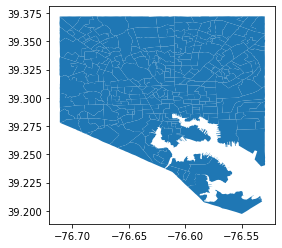

In [42]:
# plot voting district shapes
gdf_bmore.plot()

In [38]:
# remove values from 311 data that don't have location data
gdf_311_march = gdf_311_march[gdf_311_march["Latitude"].notnull()]

In [39]:
gdf_311_march.head()

,SRRecordID,CreatedDate,Latitude,Longitude,year,month,geometry
296,14-00217941,2014-03-24 17:20:20,39.306026,-76.707414,2014,3,POINT (-76.70741 39.30603)
344,14-00235168,2014-03-31 12:29:54,39.300429,-76.685411,2014,3,POINT (-76.68541 39.30043)
357,14-00214457,2014-03-24 02:10:36,39.336451,-76.661175,2014,3,POINT (-76.66118 39.33645)
423,14-00219041,2014-03-25 06:58:03,39.307900,-76.585694,2014,3,POINT (-76.58569 39.30790)
461,14-00234637,2014-03-31 10:36:53,39.304829,-76.580591,2014,3,POINT (-76.58059 39.30483)


In [40]:
# assign each point to a voter precinct
gdf_311_inprecincts = gpd.sjoin(gdf_311_march, gdf_bmore,
                               how = "left",
                               op = "within")

In [54]:
# preview merged data
gdf_311_inprecincts.head()

,SRRecordID,CreatedDate,Latitude,Longitude,year,month,geometry,index_right,JURIS,NAME,NUMBER,preid
296,14-00217941,2014-03-24 17:20:20,39.306026,-76.707414,2014,3,POINT (-76.70741 39.30603),524.0,BACI,BALTIMORE CITY PRECINCT 28-009,28-009,BACI-28-009
344,14-00235168,2014-03-31 12:29:54,39.300429,-76.685411,2014,3,POINT (-76.68541 39.30043),363.0,BACI,BALTIMORE CITY PRECINCT 16-014,16-014,BACI-16-014
357,14-00214457,2014-03-24 02:10:36,39.336451,-76.661175,2014,3,POINT (-76.66118 39.33645),347.0,BACI,BALTIMORE CITY PRECINCT 15-023,15-023,BACI-15-023
423,14-00219041,2014-03-25 06:58:03,39.307900,-76.585694,2014,3,POINT (-76.58569 39.30790),263.0,BACI,BALTIMORE CITY PRECINCT 08-007,08-007,BACI-08-007
461,14-00234637,2014-03-31 10:36:53,39.304829,-76.580591,2014,3,POINT (-76.58059 39.30483),266.0,BACI,BALTIMORE CITY PRECINCT 08-010,08-010,BACI-08-010


In [55]:
# count the number of 311 requests per precinct per year

gdf_march_agg = gdf_311_inprecincts.groupby(["year", "NUMBER"])["SRRecordID"].agg(["count"]).reset_index()

In [56]:
# preview aggregated data
gdf_march_agg.tail()

,year,NUMBER,count
2364,2020,28-011,120
2365,2020,28-012,77
2366,2020,28-013,65
2367,2020,28-014,67
2368,2020,28-015,57


## Create Choropleth Map for 2019

### Merge Population Data

In [57]:
# import election precinct population data to normalize values for choropleth
df_pop = pd.read_excel("AppB4_Adj.xls", skiprows = 10)

In [58]:
# preview data
df_pop.head()

,Unnamed: 0,GEOID,State Code,County Code,VTD Code,Voting District,2010 Census,Popn.Net Change,Net Pct Change,Final Adjusted Population
0,NaN,NaN,NaN,NaN,NaN,MARYLAND,5773552.0,-1321.0,-0.000229,5772231.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2400101-000,24,1.0,01-000,Allegany Precinct 01-000,936.0,0.0,0.000000,936.0
3,NaN,2400102-000,24,1.0,02-000,Allegany Precinct 02-000,1182.0,1.0,0.000846,1183.0
4,NaN,2400103-000,24,1.0,03-000,Allegany Precinct 03-000,1048.0,0.0,0.000000,1048.0


In [59]:
# delete first two rows after column headers
df_pop = df_pop.drop(df_pop.index[0:2])

In [60]:
# preview edited data
df_pop.head()

,Unnamed: 0,GEOID,State Code,County Code,VTD Code,Voting District,2010 Census,Popn.Net Change,Net Pct Change,Final Adjusted Population
2,NaN,2400101-000,24,1.0,01-000,Allegany Precinct 01-000,936.0,0.0,0.000000,936.0
3,NaN,2400102-000,24,1.0,02-000,Allegany Precinct 02-000,1182.0,1.0,0.000846,1183.0
4,NaN,2400103-000,24,1.0,03-000,Allegany Precinct 03-000,1048.0,0.0,0.000000,1048.0
5,NaN,2400104-002,24,1.0,04-002,Allegany Precinct 04-002,1628.0,8.0,0.004914,1636.0
6,NaN,2400104-003,24,1.0,04-003,Allegany Precinct 04-003,1921.0,8.0,0.004164,1929.0


In [68]:
# remove null values from voting population
df_pop = df_pop[df_pop["Voting District"].notnull()]

In [69]:
# keep only Baltimore City precinct rows
df_pop_bmore = df_pop[df_pop["Voting District"].str.startswith("Baltimore City")]

In [72]:
# preview data
df_pop_bmore.head()

,Unnamed: 0,GEOID,State Code,County Code,VTD Code,Voting District,2010 Census,Popn.Net Change,Net Pct Change,Final Adjusted Population
227,NaN,2451001-001,24,510.0,01-001,Baltimore City Precinct 01-001,1867.0,11.0,0.005892,1878.0
228,NaN,2451001-002,24,510.0,01-002,Baltimore City Precinct 01-002,2349.0,10.0,0.004257,2359.0
229,NaN,2451001-003,24,510.0,01-003,Baltimore City Precinct 01-003,2078.0,5.0,0.002406,2083.0
230,NaN,2451001-004,24,510.0,01-004,Baltimore City Precinct 01-004,3049.0,8.0,0.002624,3057.0
231,NaN,2451001-005,24,510.0,01-005,Baltimore City Precinct 01-005,3490.0,13.0,0.003725,3503.0


In [74]:
gdf_march_agg.head()

,year,NUMBER,count
0,2010,02-003,2
1,2010,03-003,1
2,2010,07-003,19
3,2010,08-007,1
4,2010,08-008,1


In [75]:
# merge population data onto gdf_march2020
gdf_march_pop = gdf_march_agg.merge(df_pop_bmore[["VTD Code", "Final Adjusted Population"]], 
                                    left_on = "NUMBER", 
                                    right_on = "VTD Code")

In [76]:
# preview data
gdf_march_pop.head()

,year,NUMBER,count,VTD Code,Final Adjusted Population
0,2010,02-003,2,02-003,2786.0
1,2012,02-003,1,02-003,2786.0
2,2013,02-003,17,02-003,2786.0
3,2014,02-003,479,02-003,2786.0
4,2015,02-003,260,02-003,2786.0


In [77]:
# calculate number of 311 calls per 1,000 people and round to 2 decimal places
gdf_march_pop["311_per1000"] = round(((gdf_march_pop["count"]/gdf_march_pop["Final Adjusted Population"])*1000),2)

In [78]:
# preiew data
gdf_march_pop.head()

,year,NUMBER,count,VTD Code,Final Adjusted Population,311_per1000
0,2010,02-003,2,02-003,2786.0,0.72
1,2012,02-003,1,02-003,2786.0,0.36
2,2013,02-003,17,02-003,2786.0,6.10
3,2014,02-003,479,02-003,2786.0,171.93
4,2015,02-003,260,02-003,2786.0,93.32


In [81]:
# filter df to include 2020 data
# to make static choropleth map

gdf_march2020 = gdf_march_pop[gdf_march_pop["year"]==2020]

In [82]:
gdf_march2020.head()

,year,NUMBER,count,VTD Code,Final Adjusted Population,311_per1000
9,2020,02-003,319,02-003,2786.0,114.50
17,2020,03-003,170,03-003,2098.0,81.03
26,2020,07-003,403,07-003,3761.0,107.15
36,2020,08-007,369,08-007,593.0,622.26
45,2020,08-008,45,08-008,1402.0,32.10


In [83]:
# add aggregate data onto the geodataframe

gdf_bmore2020 = gdf_bmore.merge(gdf_march2020, 
                                on = "NUMBER")

In [85]:
# preview data
gdf_bmore2020.head()

,JURIS,NAME,NUMBER,preid,geometry,year,count,VTD Code,Final Adjusted Population,311_per1000
0,BACI,BALTIMORE CITY PRECINCT 01-001,01-001,BACI-01-001,"POLYGON ((-76.57161 39.28748, -76.57156 39.286...",2020,118,01-001,1878.0,62.83
1,BACI,BALTIMORE CITY PRECINCT 01-002,01-002,BACI-01-002,"POLYGON ((-76.58455 39.28316, -76.58470 39.283...",2020,294,01-002,2359.0,124.63
2,BACI,BALTIMORE CITY PRECINCT 01-003,01-003,BACI-01-003,"POLYGON ((-76.58470 39.28305, -76.58455 39.283...",2020,154,01-003,2083.0,73.93
3,BACI,BALTIMORE CITY PRECINCT 01-004,01-004,BACI-01-004,"POLYGON ((-76.58035 39.27781, -76.58026 39.278...",2020,150,01-004,3057.0,49.07
4,BACI,BALTIMORE CITY PRECINCT 01-005,01-005,BACI-01-005,"POLYGON ((-76.57269 39.28234, -76.57342 39.282...",2020,177,01-005,3503.0,50.53


Text(0.5, 1, 'Number of Baltimore City 311 Calls per 1,000 Residents in March 2020')

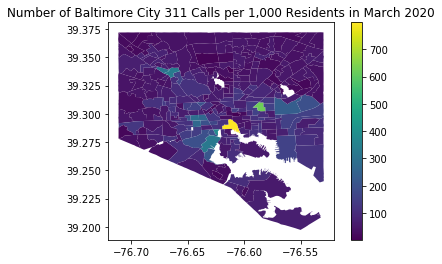

In [98]:
# plot a static choropleth map

# define both the plot and the legend
fig, ax = plt.subplots(1, 1)
# plot map
gdf_bmore2020.plot(column="311_per1000", 
                   ax=ax, 
                   legend=True,
                  figsize = (100,100))

# add title
plt.title("Number of Baltimore City 311 Calls per 1,000 Residents in March 2020")

## Convert Geopandas Dataframe into a GeoJSON object for Plotly 

More about geojsons and how they're used in plotly here: https://plotly.com/~empet/15238/tips-to-get-a-right-geojson-dict-to-defi/#/

In [100]:
gdf_bmore.head()

,JURIS,NAME,NUMBER,preid,geometry
232,BACI,BALTIMORE CITY PRECINCT 01-001,01-001,BACI-01-001,"POLYGON ((-76.57161 39.28748, -76.57156 39.286..."
233,BACI,BALTIMORE CITY PRECINCT 01-002,01-002,BACI-01-002,"POLYGON ((-76.58455 39.28316, -76.58470 39.283..."
234,BACI,BALTIMORE CITY PRECINCT 01-003,01-003,BACI-01-003,"POLYGON ((-76.58470 39.28305, -76.58455 39.283..."
235,BACI,BALTIMORE CITY PRECINCT 01-004,01-004,BACI-01-004,"POLYGON ((-76.58035 39.27781, -76.58026 39.278..."
236,BACI,BALTIMORE CITY PRECINCT 01-005,01-005,BACI-01-005,"POLYGON ((-76.57269 39.28234, -76.57342 39.282..."


In [101]:
# convert geopandas df to a geoJSON format
geojson_bmore_precincts = gdf_bmore.__geo_interface__

In [103]:
# preview geojson file
#geojson_bmore_precincts

In [104]:
# make "id" for precincts based on index
gdf_bmore["id"] = gdf_bmore.index

In [105]:
gdf_bmore.head()

,JURIS,NAME,NUMBER,preid,geometry,id
232,BACI,BALTIMORE CITY PRECINCT 01-001,01-001,BACI-01-001,"POLYGON ((-76.57161 39.28748, -76.57156 39.286...",232
233,BACI,BALTIMORE CITY PRECINCT 01-002,01-002,BACI-01-002,"POLYGON ((-76.58455 39.28316, -76.58470 39.283...",233
234,BACI,BALTIMORE CITY PRECINCT 01-003,01-003,BACI-01-003,"POLYGON ((-76.58470 39.28305, -76.58455 39.283...",234
235,BACI,BALTIMORE CITY PRECINCT 01-004,01-004,BACI-01-004,"POLYGON ((-76.58035 39.27781, -76.58026 39.278...",235
236,BACI,BALTIMORE CITY PRECINCT 01-005,01-005,BACI-01-005,"POLYGON ((-76.57269 39.28234, -76.57342 39.282...",236


In [106]:
# merge id value on 311 data
gdf_march_id = gdf_march_pop.merge(gdf_bmore[["NUMBER", "id"]], 
                                   on = "NUMBER")

In [107]:
# preview data
gdf_march_id.head()

,year,NUMBER,count,VTD Code,Final Adjusted Population,311_per1000,id
0,2010,02-003,2,02-003,2786.0,0.72,239
1,2012,02-003,1,02-003,2786.0,0.36,239
2,2013,02-003,17,02-003,2786.0,6.10,239
3,2014,02-003,479,02-003,2786.0,171.93,239
4,2015,02-003,260,02-003,2786.0,93.32,239


In [108]:
# convert precinct geodataframe to df
df_311_march_id = pd.DataFrame(gdf_march_id)

In [110]:
# preview data
df_311_march_id.head()

,year,NUMBER,count,VTD Code,Final Adjusted Population,311_per1000,id
0,2010,02-003,2,02-003,2786.0,0.72,239
1,2012,02-003,1,02-003,2786.0,0.36,239
2,2013,02-003,17,02-003,2786.0,6.10,239
3,2014,02-003,479,02-003,2786.0,171.93,239
4,2015,02-003,260,02-003,2786.0,93.32,239


## Create animated choropleth to look at changes in 311 requests in March for Baltimore City

In [120]:
# make a choropleth map of 311 calls per voting district
choropleth_311_march = px.choropleth(df_311_march_id, # dataframe with data for choropleth
                                     geojson=geojson_bmore_precincts, # shape, geospatial data geojson
                                     locations="id", # column in geojson that denotes the shapes
                                     color='311_per1000', # column in df that denotes the color scale
                                     animation_group = "year",
                                     animation_frame = "year",
                                     hover_name = df_311_march_id["NUMBER"],
                                     hover_data = ["count"],
                                     color_continuous_scale= "Viridis", 
                                     labels={'311_per1000':'Number of 311 Calls per 1,000 People',
                                             "NUMBER": "Baltimore City Precinct Number",
                                             "year": "Year",
                                             "count" : "Number of 311 Calls"
                                            }, # renaming any columns used
                                     title = "Number of 311 Calls per 1,000 People in March<br>by Baltimore City Voting Precinct",
                                     category_orders = {"year": [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]}
                                          
                          )

In [1]:
# update the geospatial boundaries of our animation
#choropleth_311_march.update_geos(fitbounds="geojson", visible=False)

In [122]:
# save animation as html
choropleth_311_march.write_html("bmore_311calls_voting_district.html")